In [2]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd() / "notebooks"))  # so we can import _utils from notebooks/

from scipy.stats import norm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from _utils import get_data_dir

DATA_DIR = get_data_dir()
DATA_DIR


WindowsPath('C:/Users/AdamR/OneDrive/UCSB/VIU/HonorsThesis/data')

In [3]:
from pyexpat import model
import pandas as pd
from pathlib import Path
from _utils import get_data_dir

ROOT = get_data_dir()
conds = ["50_50", "80_20", "100_0"]
dfs = []

def load_decisions(path, cond, model):
    df = pd.read_csv(path)
    df["stimID"] = df["image_id"]
    df["condition"] = cond
    df["participantID"] = model
    df["response"] = (
        df["GPT_response"].astype(str).str.strip().str.lower()
        .replace({"true": "present", "false": "absent"})
    )
    df["decision"] = df["response"].map({"present": 1, "absent": 0})
    return df[[
        "stimID","condition","side_selected","cue_points","line1_angle",
        "line2_angle","valid_cue","TP","response","participantID","decision"
    ]]

def parse_gemini(resp):
    a1, a2, dec = [p.strip() for p in str(resp).split(",")]
    return float(a1), float(a2), dec.lower()

for cond in conds:
    base = ROOT / cond

    # all decision models
    for f in (base / "decisions").glob("*.csv"):
        dfs.append(load_decisions(f, cond, f.stem))

    # gemini angle-estimation model
    g = pd.read_csv(base / "angle_estimations" / "gemini-2.5-pro.csv")
    g[["est1", "est2", "response"]] = pd.DataFrame(
        g["GPT_response"].apply(parse_gemini).tolist(), index=g.index
    )
    g["stimID"] = g["image_id"]
    g["condition"] = cond
    g["participantID"] = "gemini-2.5-pro"
    g["decision"] = g["response"].map({"present": 1, "absent": 0})
    dfs.append(g[[
        "stimID","condition","side_selected","cue_points","line1_angle",
        "line2_angle","valid_cue","TP","response","participantID","decision"
    ]])

model_master = pd.concat(dfs, ignore_index=True)
display(model_master)


,stimID,condition,side_selected,cue_points,line1_angle,line2_angle,valid_cue,TP,response,participantID,decision
0,100,50_50,1,2,14.314827,1.921956,False,True,present,0responses_claude-3-5-haiku-20241022,1
1,845,50_50,1,2,15.054317,4.222230,False,True,absent,0responses_claude-3-5-haiku-20241022,0
2,245,50_50,1,1,14.314827,6.508956,True,True,absent,0responses_claude-3-5-haiku-20241022,0
3,72,50_50,2,2,8.775056,15.054317,True,True,present,0responses_claude-3-5-haiku-20241022,1
4,469,50_50,2,2,4.222230,19.885165,True,True,absent,0responses_claude-3-5-haiku-20241022,0
...,...,...,...,...,...,...,...,...,...,...,...
38995,698,100_0,1,1,11.159944,6.508956,True,False,present,gemini-2.5-pro,1
38996,910,100_0,1,2,9.651833,4.986334,False,False,absent,gemini-2.5-pro,0
38997,880,100_0,2,2,4.222230,8.775056,True,False,absent,gemini-2.5-pro,0
38998,53,100_0,2,2,4.986334,11.908300,True,False,present,gemini-2.5-pro,1


In [4]:
import numpy as np
import pandas as pd

df = model_master.copy()

# ----------------------------------
# 1. Estimate shared sigma (sd) from absent trials
#    Use absolute angles, since we model |angle| ~ N(0 or 15, sigma^2)
# ----------------------------------
abs_line1_absent = df.loc[df["TP"] == 0, "line1_angle"].abs()
abs_line2_absent = df.loc[df["TP"] == 0, "line2_angle"].abs()
sigma = pd.concat([abs_line1_absent, abs_line2_absent]).std()

# Fallback just in case
if not np.isfinite(sigma) or sigma == 0:
    sigma = 1.0

# Precompute constant term (cancels, but we keep structure clear)
two_sigma2 = 2 * sigma**2

# Condition prior: P(TP=1 | condition)
prior_map = {
    "50_50": 0.5,
    "80_20": 0.8,
    "100_0": 0.99,  # approx 1.0 to avoid log(0)
}

# ----------------------------------
# 2. Build a base stimulus table (one row per stimID × condition)
# ----------------------------------
base = (
    df.drop_duplicates(["stimID", "condition"])
      .sort_values(["condition", "stimID"])
      .reset_index(drop=True)
)

bio_chunks = []

for cond, g in base.groupby("condition"):
    g = g.copy()
    
    # Absolute angles for both lines
    x1 = g["line1_angle"].abs()
    x2 = g["line2_angle"].abs()
    
    # Absent model: both sides ~ N(0, sigma^2)
    # log p0 = log N(x1;0) + log N(x2;0), constant terms cancel in LLR
    log_p0 = -((x1**2 + x2**2) / two_sigma2)
    
    # Present model: one side is target (mean 15), other non-target (mean 0)
    # Option 1: target on line1, non-target on line2
    log_p1_line1 = -(((x1 - 15)**2 + x2**2) / two_sigma2)
    
    # Option 2: target on line2, non-target on line1
    log_p1_line2 = -((x1**2 + (x2 - 15)**2) / two_sigma2)
    
    # Present likelihood is mixture of the two possibilities (target could be either line)
    # p1 = 0.5 * exp(log_p1_line1) + 0.5 * exp(log_p1_line2)
    # log p1 = log( exp(log_p1_line1 - log2) + exp(log_p1_line2 - log2) )
    log_half = -np.log(2.0)
    a = log_p1_line1 + log_half
    b = log_p1_line2 + log_half
    # log-sum-exp for numerical stability
    max_ab = np.maximum(a, b)
    log_p1 = max_ab + np.log(np.exp(a - max_ab) + np.exp(b - max_ab))
    
    # Sensory log-likelihood ratio
    LLR = log_p1 - log_p0
    
    # Prior odds from condition
    p_prior = prior_map.get(cond, 0.5)
    p_prior = np.clip(p_prior, 1e-3, 1 - 1e-3)
    prior_llr = np.log(p_prior / (1 - p_prior))
    
    # Posterior log-odds
    post_llr = LLR + prior_llr
    
    # BIO decision: 1 = present if posterior odds > 0
    bio_decision = (post_llr > 0).astype(int)
    
    # Build BIO rows matching model_master schema
    g_bio = g.copy()
    g_bio["participantID"] = "BIO"
    g_bio["response"] = bio_decision  # if you want, you can treat this as binary confidence
    g_bio["decision"] = bio_decision
    
    bio_chunks.append(g_bio)

# ----------------------------------
# 3. Combine all BIO trials and attach to model_master
# ----------------------------------
BIO_df = pd.concat(bio_chunks, ignore_index=True)

model_master_with_BIO = pd.concat([df, BIO_df], ignore_index=True)

print("Original model_master shape:", df.shape)
print("BIO trials shape:", BIO_df.shape)
print("model_master_with_BIO shape:", model_master_with_BIO.shape)
model_master_with_BIO.tail()


Original model_master shape: (39000, 11)
BIO trials shape: (3000, 11)
model_master_with_BIO shape: (42000, 11)


,stimID,condition,side_selected,cue_points,line1_angle,line2_angle,valid_cue,TP,response,participantID,decision
41995,996,80_20,1,1,15.788708,1.921956,True,True,1,BIO,1
41996,997,80_20,1,1,1.153450,11.159944,True,False,1,BIO,1
41997,998,80_20,2,2,4.986334,1.153450,True,False,0,BIO,0
41998,999,80_20,1,1,1.921956,-1.153450,True,False,0,BIO,0
41999,1000,80_20,1,2,14.314827,4.986334,False,True,1,BIO,1


In [5]:
#All Models Metrics Table

df = model_master_with_BIO.copy()

def compute_sdt(df):
    hits = ((df["TP"]==1) & (df["decision"]==1)).mean()
    fas  = ((df["TP"]==0) & (df["decision"]==1)).mean()

    # Add tiny epsilon to avoid inf in z-scores
    eps = 1e-6
    dprime = norm.ppf(min(max(hits, eps), 1-eps)) - norm.ppf(min(max(fas, eps), 1-eps))
    crit   = -0.5*( norm.ppf(min(max(hits, eps), 1-eps)) + 
                    norm.ppf(min(max( fas, eps), 1-eps)) )
    return hits, fas, dprime, crit

rows = []
for (model, cond), g in df.groupby(["participantID","condition"]):
    acc = (g["decision"] == g["TP"]).mean()
    hits, fas, dp, c = compute_sdt(g)
    rows.append({
        "participantID": model,
        "condition": cond,
        "n_trials": len(g),
        "accuracy": acc,
        "hit_rate": hits,
        "fa_rate": fas,
        "dprime": dp,
        "criterion": c
    })

AMM = pd.DataFrame(rows)
AMM

,participantID,condition,n_trials,accuracy,hit_rate,fa_rate,dprime,criterion
0,0responses_claude-3-5-haiku-20241022,100_0,1000,0.486,0.182,0.196,-0.051774,0.881883
1,0responses_claude-3-5-haiku-20241022,50_50,1000,0.460,0.178,0.218,-0.144048,0.850990
2,0responses_claude-3-5-haiku-20241022,80_20,1000,0.490,0.176,0.186,-0.037984,0.911725
3,0responses_claude-3-7-sonnet-20250219,100_0,1000,0.490,0.238,0.248,-0.031954,0.696774
4,0responses_claude-3-7-sonnet-20250219,50_50,1000,0.498,0.211,0.213,-0.006901,0.799506
5,0responses_claude-3-7-sonnet-20250219,80_20,1000,0.483,0.235,0.252,-0.054270,0.695344
6,0responses_claude-opus-4-20250514,100_0,1000,0.473,0.179,0.206,-0.098804,0.869781
7,0responses_claude-opus-4-20250514,50_50,1000,0.479,0.170,0.191,-0.079948,0.914191
8,0responses_claude-opus-4-20250514,80_20,1000,0.477,0.180,0.203,-0.084412,0.873159
9,0responses_claude-sonnet-4-20250514,100_0,1000,0.486,0.331,0.345,-0.038298,0.418004


In [6]:
#hit rate vs invalid HR Table
df = model_master.copy()

# --- 1. Compute hit indicator for TP=1 trials ---
hits = (
    df[df["TP"] == True]
      .assign(hit=lambda d: (d["decision"] == 1).astype(int))
      .groupby(["participantID", "condition", "valid_cue"], as_index=False)["hit"]
      .mean()
)

# --- 2. Pivot valid vs invalid hit rates ---
hr_table = (
    hits.pivot(index=["participantID", "condition"],
               columns="valid_cue", values="hit")
        .rename(columns={0: "hr_invalid", 1: "hr_valid"})
        .reset_index()
)

# --- 3. Add ΔHR (cue advantage) ---
hr_table["delta_hr"] = hr_table["hr_valid"] - hr_table["hr_invalid"]

hr_table


valid_cue,participantID,condition,hr_invalid,hr_valid,delta_hr
0,0responses_claude-3-5-haiku-20241022,100_0,NaN,0.364000,NaN
1,0responses_claude-3-5-haiku-20241022,50_50,0.337398,0.374016,0.036617
2,0responses_claude-3-5-haiku-20241022,80_20,0.280899,0.367397,0.086498
3,0responses_claude-3-7-sonnet-20250219,100_0,NaN,0.476000,NaN
4,0responses_claude-3-7-sonnet-20250219,50_50,0.443089,0.401575,-0.041515
5,0responses_claude-3-7-sonnet-20250219,80_20,0.404494,0.484185,0.079691
6,0responses_claude-opus-4-20250514,100_0,NaN,0.358000,NaN
7,0responses_claude-opus-4-20250514,50_50,0.333333,0.346457,0.013123
8,0responses_claude-opus-4-20250514,80_20,0.314607,0.369830,0.055223
9,0responses_claude-sonnet-4-20250514,100_0,NaN,0.662000,NaN


C:\Users\AdamR\AppData\Local\Temp\ipykernel_22564\2315903512.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hr_plot["below_diag"] = hr_plot["hr_valid"] < hr_plot["hr_invalid"]


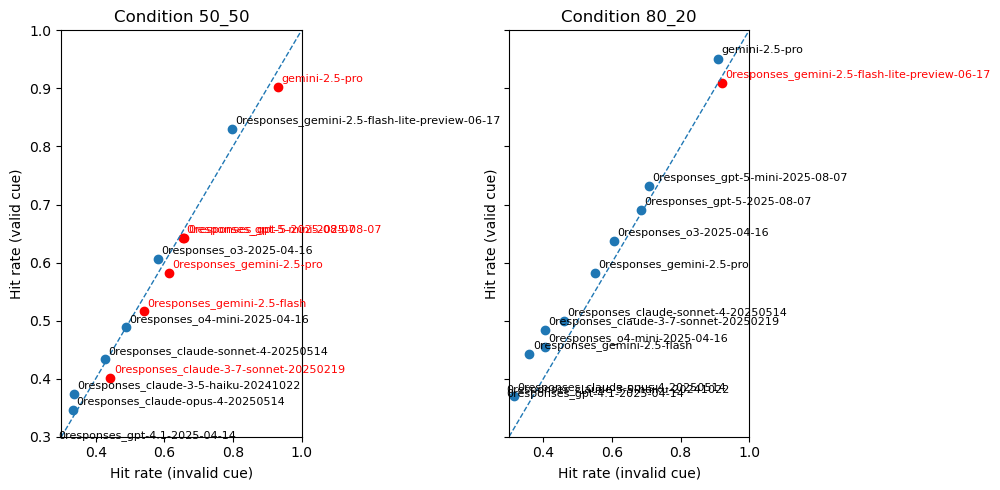

Models below diagonal (valid HR < invalid HR) in 50_50 or 80_20:


valid_cue,participantID,condition,hr_invalid,hr_valid
4,0responses_claude-3-7-sonnet-20250219,50_50,0.443089,0.401575
13,0responses_gemini-2.5-flash,50_50,0.540650,0.515748
17,0responses_gemini-2.5-flash-lite-preview-06-17,80_20,0.921348,0.909976
19,0responses_gemini-2.5-pro,50_50,0.613821,0.582677
25,0responses_gpt-5-2025-08-07,50_50,0.658537,0.641732
28,0responses_gpt-5-mini-2025-08-07,50_50,0.654472,0.641732
37,gemini-2.5-pro,50_50,0.930894,0.901575


In [7]:
#HR Plot
df = model_master.copy()

# --- 1. Hit rate by valid_cue for each model × condition ---
hits = (
    df[df["TP"] == 1]
      .assign(hit=lambda d: (d["decision"] == 1).astype(int))
      .groupby(["participantID", "condition", "valid_cue"], as_index=False)["hit"]
      .mean()
)

# Pivot to valid vs invalid cue hit rates
hr = (
    hits.pivot(index=["participantID", "condition"],
               columns="valid_cue", values="hit")
        .rename(columns={0: "hr_invalid", 1: "hr_valid"})
        .reset_index()
)

# Only plot 50_50 and 80_20
hr_plot = hr[hr["condition"].isin(["50_50", "80_20"])]

# Identify models below the diagonal
hr_plot["below_diag"] = hr_plot["hr_valid"] < hr_plot["hr_invalid"]

# --- 3. Plot with zoomed axes ---
conds = ["50_50", "80_20"]
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

for ax, cond in zip(axes, conds):
    sub = hr_plot[hr_plot["condition"] == cond]

    # Above/on diagonal
    good = sub[~sub["below_diag"]]
    ax.scatter(good["hr_invalid"], good["hr_valid"])
    for _, row in good.iterrows():
        ax.text(row["hr_invalid"] + 0.01, row["hr_valid"] + 0.01,
                row["participantID"], fontsize=8)

    # Below diagonal (red)
    bad = sub[sub["below_diag"]]
    ax.scatter(bad["hr_invalid"], bad["hr_valid"], color="red")
    for _, row in bad.iterrows():
        ax.text(row["hr_invalid"] + 0.01, row["hr_valid"] + 0.01,
                row["participantID"], fontsize=8, color="red")

    # Diagonal line
    ax.plot([0.3, 1], [0.3, 1], linestyle="--", linewidth=1)

    ax.set_title(f"Condition {cond}")
    ax.set_xlabel("Hit rate (invalid cue)")
    ax.set_ylabel("Hit rate (valid cue)")
    ax.set_xlim(0.3, 1)
    ax.set_ylim(0.3, 1)

plt.tight_layout()
plt.show()

# --- 4. Print bad models ---
bad_models = (
    hr_plot[hr_plot["below_diag"]]
    .sort_values(["participantID", "condition"])
    [["participantID", "condition", "hr_invalid", "hr_valid"]]
)

print("Models below diagonal (valid HR < invalid HR) in 50_50 or 80_20:")
display(bad_models)


In [8]:
#Top 8 Models by Simple Hit Rate and Cue Advantage
df = model_master.copy()

hits = (
    df[df["TP"] == 1]
      .assign(hit=lambda d: (d["decision"] == 1).astype(int))
      .groupby(["participantID", "condition", "valid_cue"], as_index=False)["hit"]
      .mean()
)


hr = (
    hits.pivot(index=["participantID", "condition"],
               columns="valid_cue", values="hit")
        .rename(columns={0: "hr_invalid", 1: "hr_valid"})
        .reset_index()
)


hr = hr[hr["condition"].isin(["50_50", "80_20"])]


hr["delta_hr"] = hr["hr_valid"] - hr["hr_invalid"]


model_hr = (
    hr.groupby("participantID", as_index=False)
      .agg(mean_hr_valid=("hr_valid", "mean"),
           mean_delta_hr=("delta_hr", "mean"))
)


model_hr["score"] = model_hr["mean_hr_valid"] + model_hr["mean_delta_hr"]


best8_simple = model_hr.sort_values("score", ascending=False).head(8)
best8_names = best8_simple["participantID"].tolist()

BMM = model_master[model_master["participantID"].isin(best8_names)].copy()


display(BMM.head())

,stimID,condition,side_selected,cue_points,line1_angle,line2_angle,valid_cue,TP,response,participantID,decision
4000,100,50_50,1,2,14.314827,1.921956,False,True,absent,0responses_gemini-2.5-flash-lite-preview-06-17,0
4001,845,50_50,1,2,15.054317,4.222230,False,True,absent,0responses_gemini-2.5-flash-lite-preview-06-17,0
4002,245,50_50,1,1,14.314827,6.508956,True,True,present,0responses_gemini-2.5-flash-lite-preview-06-17,1
4003,72,50_50,2,2,8.775056,15.054317,True,True,present,0responses_gemini-2.5-flash-lite-preview-06-17,1
4004,469,50_50,2,2,4.222230,19.885165,True,True,absent,0responses_gemini-2.5-flash-lite-preview-06-17,0


In [9]:
#model metrics and aggregation

df = BMM.copy()

# Ensure decisions are numeric 0/1
df["decision"] = df["decision"].astype(int)

# -----------------------------
# 1. Per-model SDT metrics
# -----------------------------
def sdt_metrics_group(g):
    n = len(g)
    tp1 = g["TP"] == 1
    tp0 = ~tp1
    resp1 = g["decision"] == 1

    hits = (resp1 & tp1).sum()
    fas  = (resp1 & tp0).sum()
    correct = hits + ((~resp1) & tp0).sum()

    hit_rate = hits / tp1.sum()
    fa_rate  = fas  / tp0.sum()
    accuracy = correct / n

    eps_H = 1 / (2 * tp1.sum())
    eps_F = 1 / (2 * tp0.sum())
    H = min(max(hit_rate, eps_H), 1 - eps_H)
    F = min(max(fa_rate,  eps_F), 1 - eps_F)

    dprime = norm.ppf(H) - norm.ppf(F)
    criterion = -0.5 * (norm.ppf(H) + norm.ppf(F))

    return pd.Series({
        "n_trials": n,
        "accuracy": accuracy,
        "hit_rate": hit_rate,
        "fa_rate": fa_rate,
        "dprime": dprime,
        "criterion": criterion,
    })

model_participant_metrics = (
    df.groupby(["participantID", "condition"])
      .apply(sdt_metrics_group)
      .reset_index()
)

# -----------------------------
# 2. Aggregation-level metrics
# -----------------------------
def sdt_from_binary(decisions, TPs):
    decisions = np.asarray(decisions).astype(int)
    TPs = np.asarray(TPs).astype(int)
    n = len(decisions)

    tp1 = TPs == 1
    tp0 = ~tp1
    resp1 = decisions == 1

    hits = (resp1 & tp1).sum()
    fas  = (resp1 & tp0).sum()
    correct = hits + ((~resp1) & tp0).sum()

    hit_rate = hits / tp1.sum()
    fa_rate  = fas  / tp0.sum()
    accuracy = correct / n

    eps = 1e-5
    hit_rate = np.clip(hit_rate, eps, 1 - eps)
    fa_rate  = np.clip(fa_rate,  eps, 1 - eps)

    zH, zF = norm.ppf(hit_rate), norm.ppf(fa_rate)
    dprime = zH - zF
    c = -0.5 * (zH + zF)
    return accuracy, hit_rate, fa_rate, dprime, c

rows = []

for cond, df_c in df.groupby("condition"):
    # decisions per stimID × model (numeric)
    dec_piv = df_c.pivot_table(
        index="stimID",
        columns="participantID",
        values="decision",
        aggfunc="mean"
    )

    # majority vote across models
    maj = (dec_piv.mean(axis=1) > 0.5).astype(int).values

    # Gemini decider: use gemini-2.5-pro's decision
    gem = (dec_piv["gemini-2.5-pro"] > 0.5).astype(int).values

    # TPs aligned to stimID order
    trials = df_c.drop_duplicates("stimID").set_index("stimID").loc[dec_piv.index]
    TPs = trials["TP"].astype(int).values

    # Gemini-based positive exception:
    # if Gemini says present -> 1, else majority
    pos_ex = np.where(gem == 1, 1, maj)

    # Gemini-based negative exception:
    # if Gemini says absent -> 0, else majority
    neg_ex = np.where(gem == 0, 0, maj)

    for name, decisions in [
        ("majority", maj),
        ("maj_pos_exception", pos_ex),
        ("maj_neg_exception", neg_ex),
    ]:
        acc, H, F, dp, c = sdt_from_binary(decisions, TPs)
        rows.append({
            "aggregation": name,
            "condition": cond,
            "n_trials": len(decisions),
            "accuracy": acc,
            "hit_rate": H,
            "fa_rate": F,
            "dprime": dp,
            "criterion": c,
        })

# -----------------------------
# 3. Best individual model per condition
# -----------------------------
best_rows = []
for cond, df_c in df.groupby("condition"):
    stats = []
    for pid, dfg in df_c.groupby("participantID"):
        acc, hit, fa, dp, c = sdt_from_binary(dfg["decision"], dfg["TP"])
        stats.append((pid, acc, hit, fa, dp, c))

    pid, acc, hit, fa, dp, c = max(stats, key=lambda x: x[1])
    best_rows.append({
        "aggregation": "best_individual",
        "condition": cond,
        "n_trials": len(df_c),
        "accuracy": acc,
        "hit_rate": hit,
        "fa_rate": fa,
        "dprime": dp,
        "criterion": c,
        "who": pid
    })


# -----------------------------
# 5. Final: model_agg table
# -----------------------------
model_agg = pd.DataFrame(rows)
model_agg = pd.concat([model_agg, pd.DataFrame(best_rows)], ignore_index=True)

display(model_agg)


C:\Users\AdamR\AppData\Local\Temp\ipykernel_22564\651683554.py:44: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(sdt_metrics_group)


,aggregation,condition,n_trials,accuracy,hit_rate,fa_rate,dprime,criterion,who
0,majority,100_0,1000,0.498,0.556,0.560,-0.010134,-0.145902,NaN
1,maj_pos_exception,100_0,1000,0.665,0.992,0.662,1.990988,-1.413422,NaN
2,maj_neg_exception,100_0,1000,0.704,0.534,0.126,1.230834,0.530088,NaN
3,majority,50_50,1000,0.501,0.618,0.616,0.005240,-0.297612,NaN
4,maj_pos_exception,50_50,1000,0.650,0.974,0.674,1.492148,-1.197060,NaN
5,maj_neg_exception,50_50,1000,0.716,0.560,0.128,1.286865,0.492464,NaN
6,majority,80_20,1000,0.517,0.636,0.602,0.089260,-0.303157,NaN
7,maj_pos_exception,80_20,1000,0.640,0.976,0.696,1.464438,-1.245149,NaN
8,maj_neg_exception,80_20,1000,0.722,0.604,0.160,1.258172,0.365372,NaN
9,best_individual,100_0,8000,0.871,0.970,0.228,2.626243,-0.567672,gemini-2.5-pro


In [10]:
model_participant_metrics

,participantID,condition,n_trials,accuracy,hit_rate,fa_rate,dprime,criterion
0,0responses_gemini-2.5-flash,100_0,1000.0,0.483,0.528,0.562,-0.085799,-0.113143
1,0responses_gemini-2.5-flash,50_50,1000.0,0.480,0.528,0.568,-0.101041,-0.120764
2,0responses_gemini-2.5-flash,80_20,1000.0,0.484,0.428,0.460,-0.081035,0.140951
3,0responses_gemini-2.5-flash-lite-preview-06-17,100_0,1000.0,0.507,0.752,0.738,0.043605,-0.658994
4,0responses_gemini-2.5-flash-lite-preview-06-17,50_50,1000.0,0.489,0.814,0.836,-0.085417,-0.935442
5,0responses_gemini-2.5-flash-lite-preview-06-17,80_20,1000.0,0.497,0.912,0.918,-0.038570,-1.372459
6,0responses_gemini-2.5-pro,100_0,1000.0,0.478,0.516,0.560,-0.110852,-0.095543
7,0responses_gemini-2.5-pro,50_50,1000.0,0.499,0.598,0.600,-0.005173,-0.250760
8,0responses_gemini-2.5-pro,80_20,1000.0,0.492,0.576,0.592,-0.041022,-0.212182
9,0responses_gpt-5-2025-08-07,100_0,1000.0,0.475,0.570,0.620,-0.129107,-0.240927


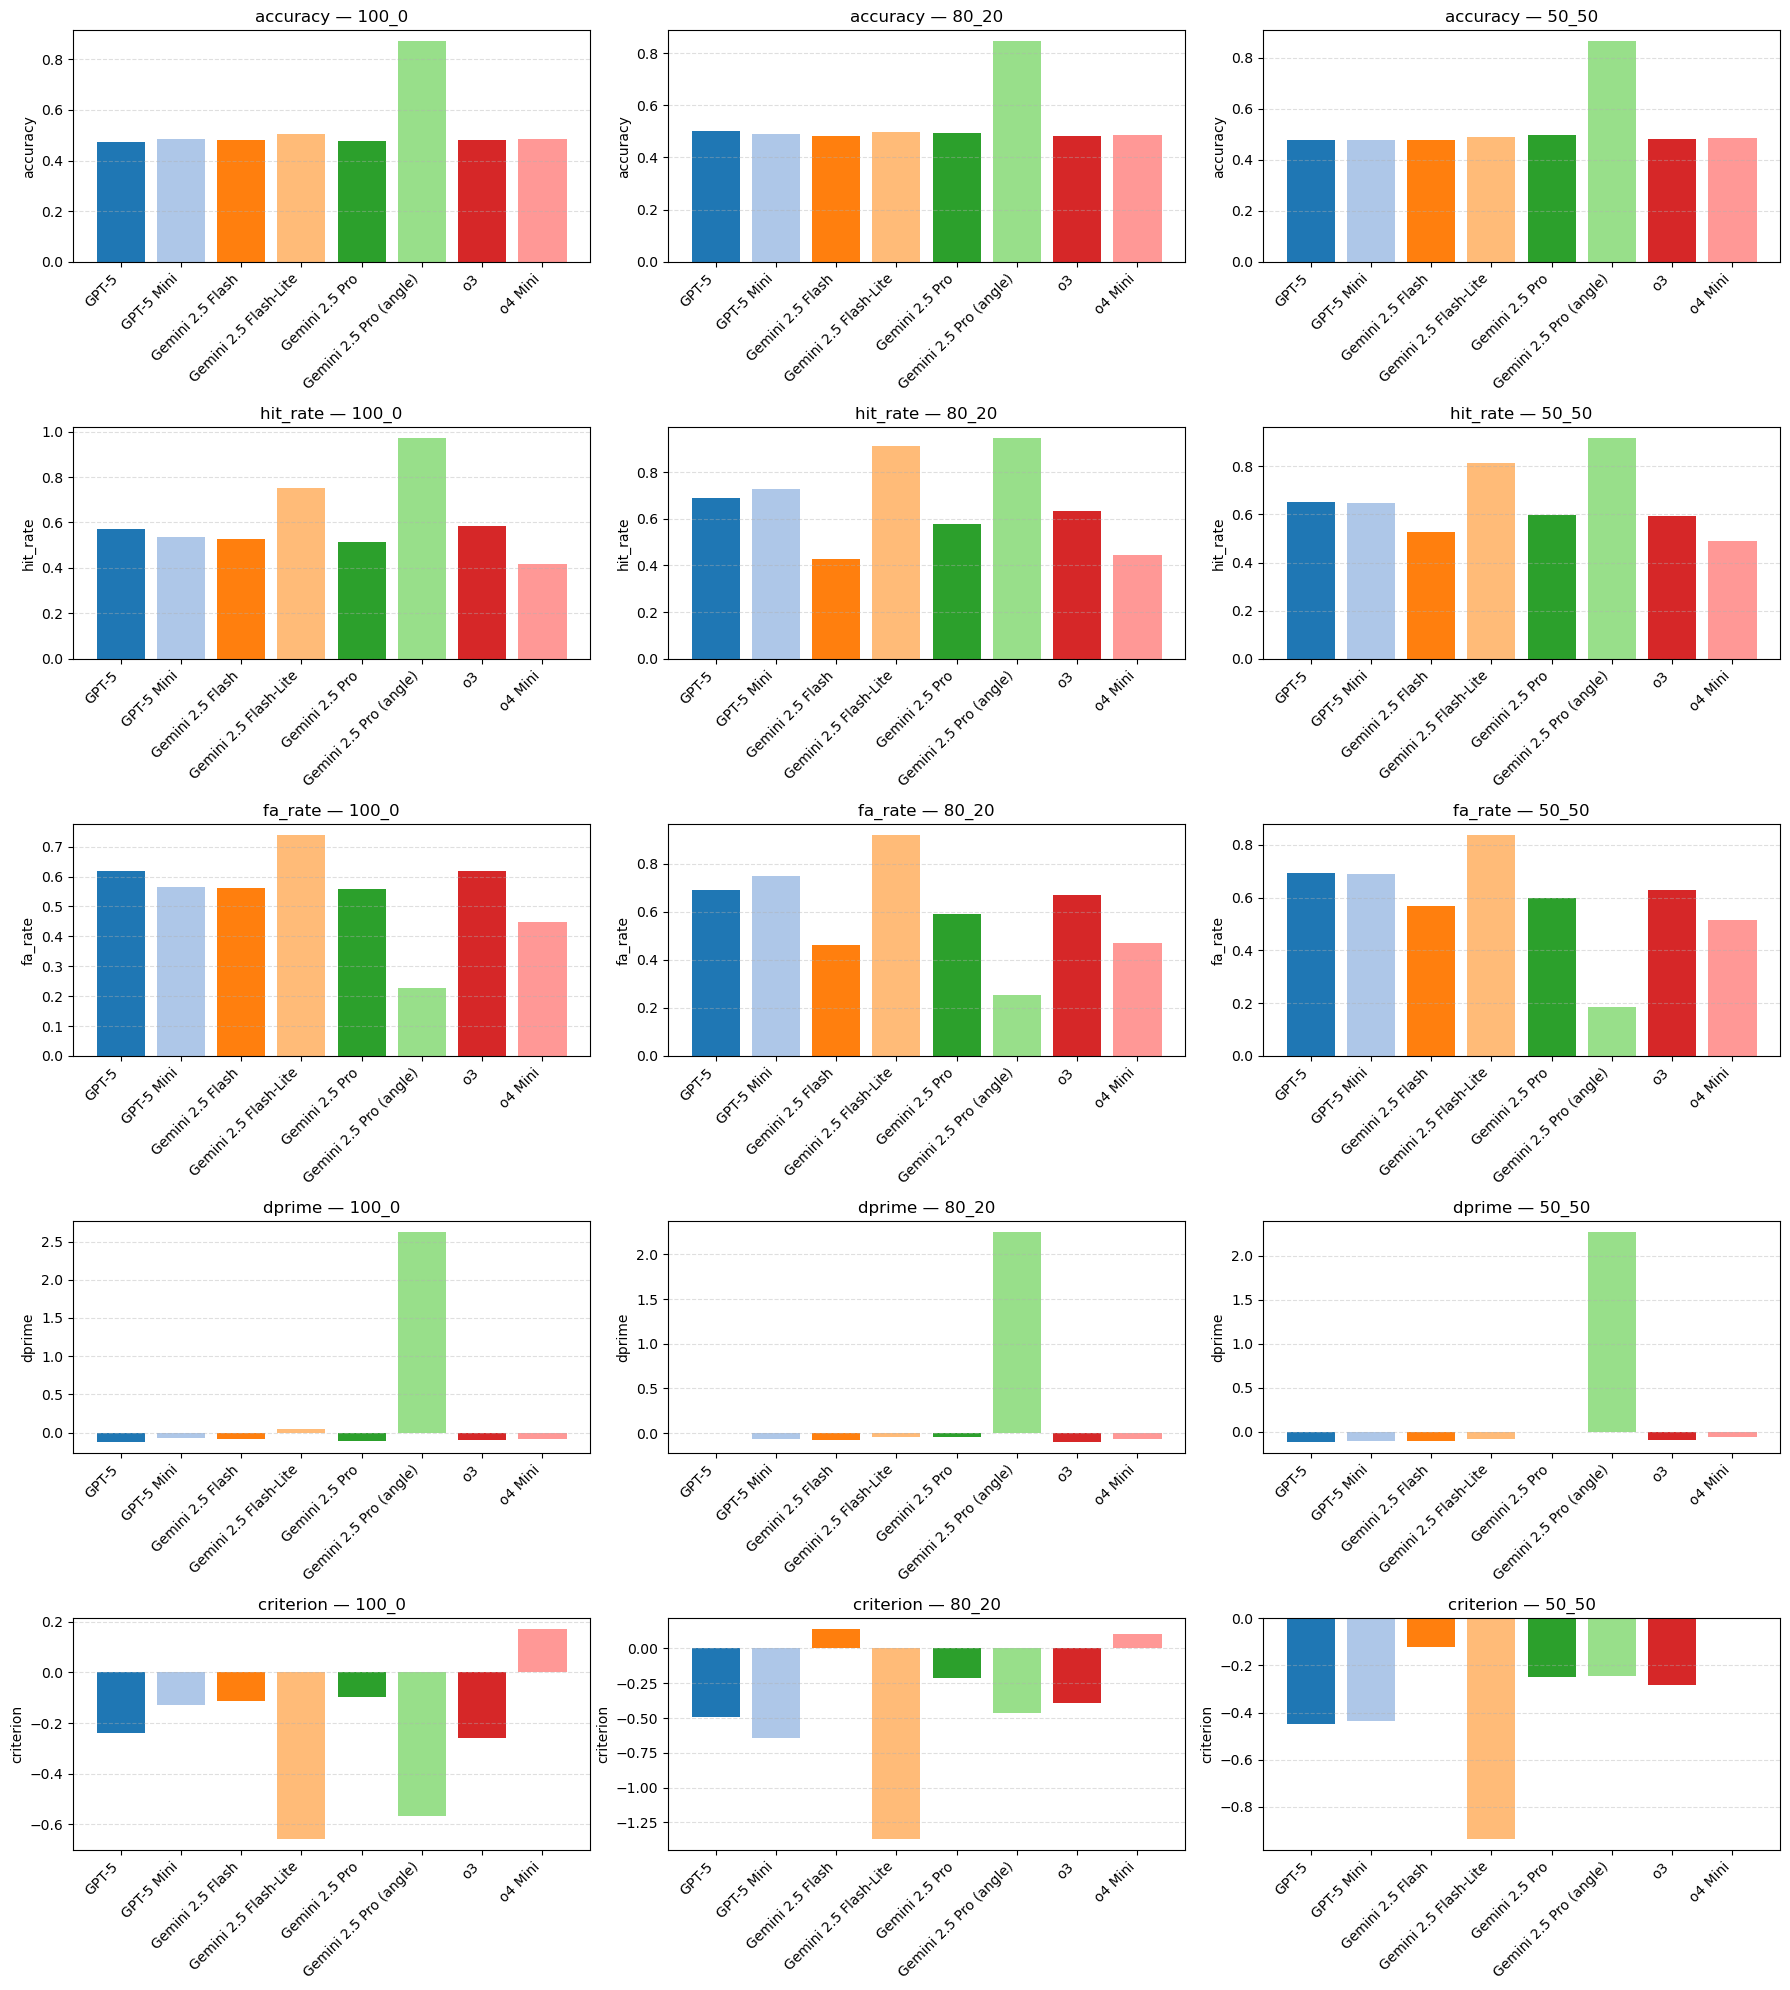

In [13]:
#plotting individual models
mpm = model_participant_metrics.copy()

name_map = {
    "0responses_gemini-2.5-flash": "Gemini 2.5 Flash",
    "0responses_gemini-2.5-flash-lite-preview-06-17": "Gemini 2.5 Flash-Lite",
    "0responses_gemini-2.5-pro": "Gemini 2.5 Pro",
    "0responses_gpt-5-2025-08-07": "GPT-5",
    "0responses_gpt-5-mini-2025-08-07": "GPT-5 Mini",
    "0responses_o3-2025-04-16": "o3",
    "0responses_o4-mini-2025-04-16": "o4 Mini",
    "gemini-2.5-pro": "Gemini 2.5 Pro (angle)",
}

mpm["model_label"] = mpm["participantID"].map(name_map).fillna(mpm["participantID"])

# --------------------------
# Define metrics & conditions
# --------------------------
metrics = ["accuracy", "hit_rate", "fa_rate", "dprime", "criterion"]
conds = sorted(mpm["condition"].unique())

models_sorted = sorted(mpm["model_label"].unique())

# Assign consistent colors
colors = {m: plt.cm.tab20(i % 20) for i, m in enumerate(models_sorted)}

conds = ["100_0", "80_20", "50_50"]

fig, axes = plt.subplots(
    len(metrics), len(conds),
    figsize=(6 * len(conds), 4 * len(metrics)),
    sharey=False
)

if len(conds) == 1:
    axes = np.array([axes]).reshape(len(metrics), 1)


for i, metric in enumerate(metrics):
    for j, cond in enumerate(conds):
        ax = axes[i, j]
        
        # Filter data for this condition
        sub = mpm[mpm["condition"] == cond].copy()
        
        # Reindex to FIXED model ordering (keeps ordering constant)
        sub = sub.set_index("model_label").reindex(models_sorted).reset_index()
        
        # x positions always same order
        x = np.arange(len(sub))
        
        # Plot bars
        ax.bar(
            x,
            sub[metric],
            color=[colors[m] for m in sub["model_label"]]
        )

        # Set ticks *then* labels (avoids warnings)
        ax.set_xticks(x)
        ax.set_xticklabels(sub["model_label"], rotation=45, ha="right")

        ax.set_title(f"{metric} — {cond}", fontsize=12)
        ax.set_ylabel(metric)
        ax.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()